In [1]:
import arviz as az
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from pywhy_graphs.viz import draw
import pymc as pm
from scipy import stats
import warnings

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
warnings.filterwarnings('ignore')

1\. The first two problems are based on the same data. The data in data(foxes) are 116 foxes from 30 different urban groups in England. These fox groups are like street gangs. Group size (groupsize) varies from 2 to 8 individuals. Each group maintains its own (almost exclusive) urban territory. Some territories are larger than others. The area variable encodes this information. Some territories also have more avgfood than others. And food influences the weight of each fox. Assume this DAG:
A
F G
W
where F is avgfood, G is groupsize, A is area, and W is weight.
Use the backdoor criterion and estimate the total causal influence of A on F. What effect would increasing the area of a territory have on the amount
of food inside it?

In [3]:
d = pd.read_csv("../../Data/foxes.csv", sep=",", header=0)
d.head(10)

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85
5,3,0.49,2,2.12,3.25
6,4,0.45,2,1.29,4.53
7,4,0.45,2,1.29,4.09
8,5,0.74,3,3.78,6.13
9,5,0.74,3,3.78,5.59


In [4]:
az.summary(d.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
group,17.207,8.003,5.00,29.00
avgfood,0.752,0.198,0.41,1.03
groupsize,4.345,1.539,2.00,7.00
area,3.169,0.928,1.73,4.54
weight,4.530,1.184,2.78,6.31


Let's standardize the data.

In [5]:
d_standardized = d
d_standardized.avgfood = stats.zscore(d_standardized.avgfood)
d_standardized.groupsize = stats.zscore(d_standardized.groupsize)
d_standardized.area = stats.zscore(d_standardized.area)
d_standardized.weight = stats.zscore(d_standardized.weight)
d_standardized.head(10)

,group,avgfood,groupsize,area,weight
0,1,-1.933180,-1.530701,-2.249313,0.415931
1,1,-1.933180,-1.530701,-2.249313,-1.433238
2,2,-1.122886,-1.530701,-1.210738,0.678887
3,2,-1.122886,-1.530701,-1.210738,1.306586
4,3,-1.325459,-1.530701,-1.135008,1.119973
5,3,-1.325459,-1.530701,-1.135008,-1.085458
6,4,-1.528033,-1.530701,-2.032943,0.000292
7,4,-1.528033,-1.530701,-2.032943,-0.372934
8,5,-0.059375,-0.877902,0.660860,1.357481
9,5,-0.059375,-0.877902,0.660860,0.899430


In [6]:
az.summary(d_standardized.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
group,17.207,8.003,5.000,29.000
avgfood,0.000,1.004,-1.731,1.409
groupsize,-0.000,1.004,-1.531,1.733
area,-0.000,1.004,-1.557,1.483
weight,0.000,1.004,-1.484,1.510


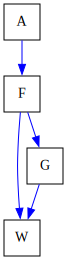

In [7]:
G = nx.DiGraph([("A", "F"), ("F", "W"), ("F", "G"), ("G", "W")])
draw(G, node_shapes="o")

Because there are no back-door paths from area to avgfood, we only need to include area to the causal effect of area. No other variables are needed. In fact, adding other variables could cause bias.

In [8]:
F = d_standardized.avgfood.values
A = d_standardized.area.values
W = d_standardized.weight.values
G = d_standardized.groupsize.values

Text(0, 0.5, 'F')

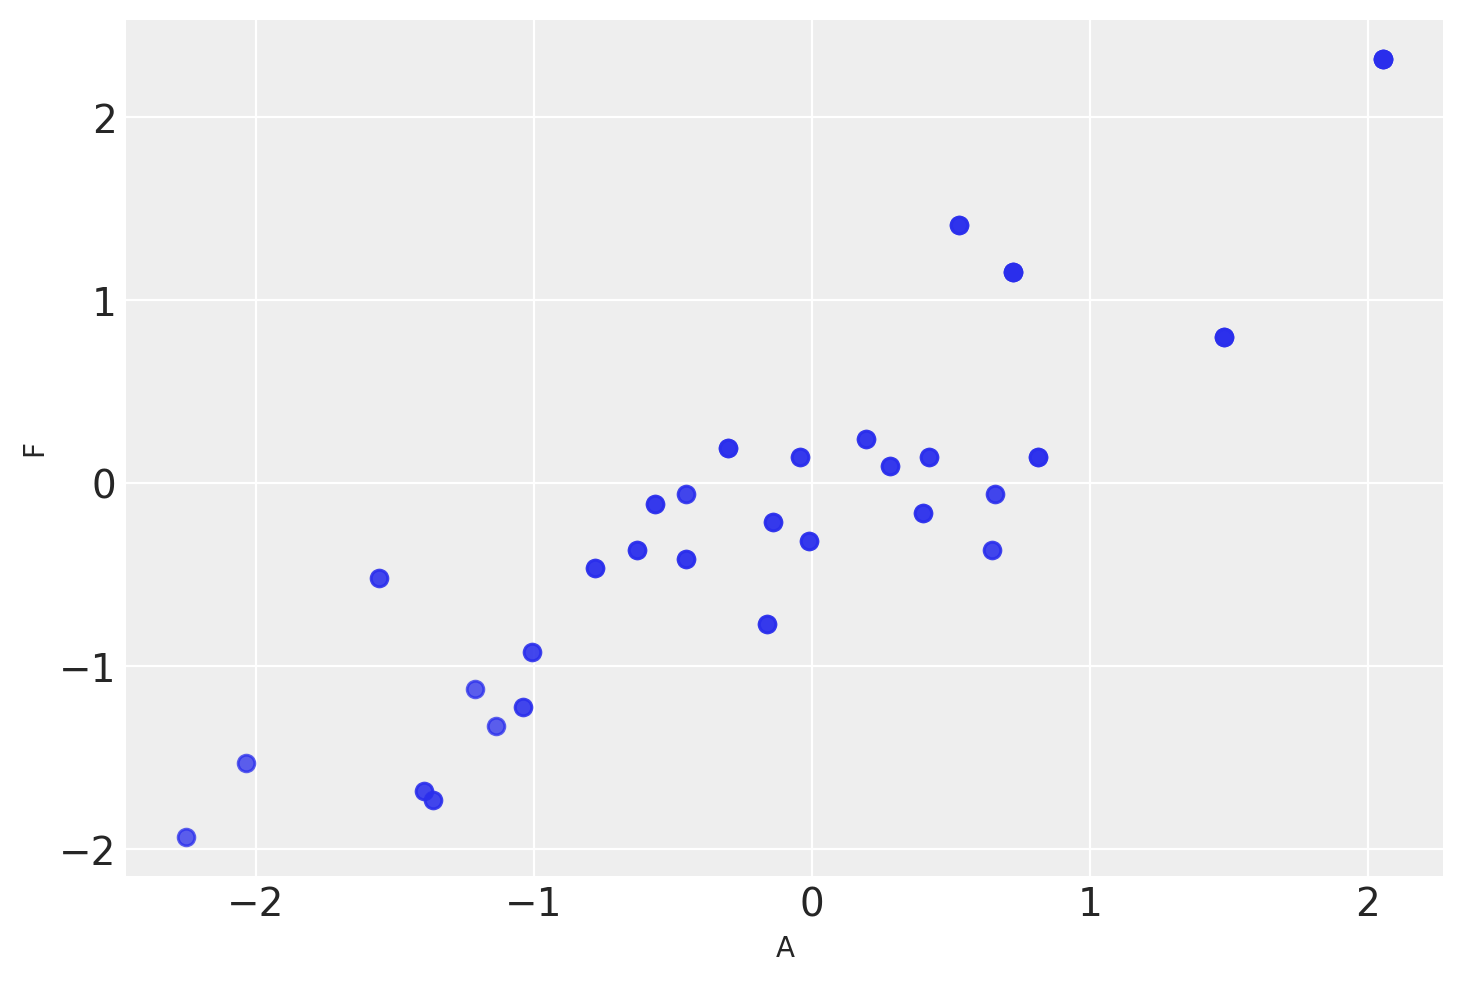

In [9]:
_, (ax0) = plt.subplots()
ax0.plot(A, F, "o", alpha=0.5)
ax0.set_xlabel("A")
ax0.set_ylabel("F")

In [10]:
F = d_standardized.avgfood.values
A = d_standardized.area.values

with pm.Model() as m:
    bA = pm.Normal("bA", 0., 0.5)
    a = pm.Normal("a", mu=0., sigma=0.2)
    sigma = pm.Exponential("sigma", 1.0)
    mu =  a + bA*A
    F = pm.Normal("F", mu=mu, sigma=sigma, observed=F)

In [11]:
with m:
    t = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bA, a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
az.plot_trace(t)

array([[<Axes: title={'center': 'bA'}>, <Axes: title={'center': 'bA'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

In [ ]:
az.summary(t, round_to=2, kind="stats")

Territory size seems to have a substantial effect on food availability. These are standardized variables, so bA above means that each standard deviation change in area results on average in about 0.9 standard deviations of change in food availability.

2\. Infer the total causal effect of adding food F to a territory on the weight W of foxes. Can you calculate the causal effect by simulating an intervention on food?

To infer the causal influence of avg food on weight,we need to close any back-door paths. There are no back-door paths in the DAG. So again, just use a model with a single predictor.

In [14]:
F = d_standardized.avgfood.values
W = d_standardized.weight.values

with pm.Model() as m:
    bF = pm.Normal("bF", 0., 0.5)
    a = pm.Normal("a", mu=0., sigma=0.2)
    sigma = pm.Exponential("sigma", 1.0)
    mu =  a + bF*F
    W = pm.Normal("W", mu=mu, sigma=sigma, observed=W)

In [15]:
with m:
    t = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bF, a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [16]:
az.plot_trace(t)

array([[<Axes: title={'center': 'bF'}>, <Axes: title={'center': 'bF'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

In [17]:
az.summary(t, round_to=2, kind="stats")

There seems to be only a small total effect of food on weight, if there is any effect at all. It’s about equally plausible that it’s negative as positive, and it’s small either way.

3\. Infer the direct causal effect of adding food F to a territory on the weight W of foxes. In light of your estimates from this problem and the previous one, what do you think is going on with these foxes?

For the direct effect we need to block the mediated path through group size G. That means stratify by group size.

In [18]:
F = d_standardized.avgfood.values
W = d_standardized.weight.values
G = d_standardized.groupsize.values

with pm.Model() as m:
    bG = pm.Normal("bG", 0., 0.5)
    bF = pm.Normal("bF", 0., 0.5)
    a = pm.Normal("a", mu=0., sigma=0.2)
    sigma = pm.Exponential("sigma", 1.0)
    mu =  a + bF*F + bG*G
    W = pm.Normal("W", mu=mu, sigma=sigma, observed=W)

In [19]:
with m:
    t = pm.sample(1000, tune=1000)

In [20]:
az.plot_trace(t)

In [21]:
az.summary(t, round_to=2, kind="stats")

The direct effect of food on weight is positive (0.19–0.76), it seems. That makes sense. This model also gives us the direct effect (also the total effect) of group size on weight. And it is the opposite and of the same magnitude as the direct effect of food. These two effects seem to cancel one another. That may be why the total effect of food is about zero: the direct effect is positive but the mediated effect through groups size is negative.

What is going on here? Larger territories increase available food (problem 1). But increases in food (and territory) do not influence fox weight. The reason seems to be because adding more food directly increases weight, but the path through group size cancels that increase. To check this idea, we can estimate the causal effect of food on groups size:

In [22]:
F = d_standardized.avgfood.values
G = d_standardized.groupsize.values

with pm.Model() as m:
    bF = pm.Normal("bF", 0., 0.5)
    a = pm.Normal("a", mu=0., sigma=0.2)
    sigma = pm.Exponential("sigma", 1.0)
    mu =  a + bF*F
    G = pm.Normal("G", mu=mu, sigma=sigma, observed=G)

In [23]:
with m:
    t = pm.sample(1000, tune=1000)

In [24]:
az.plot_trace(t)

In [26]:
az.summary(t, round_to=2, kind="stats")

Food appears to have a reliably large (0.83–0.96) effect on group size. That is, more food means more foxes. This is consistent with the idea that the mediating influence of group size cancels the direct influence of more food on individual fox body weight. In simple terms, the benefits of more food are canceled by more foxes being attracted to the food, so each fox gets the same amount.

The ecologists will recognize this situation as an ideal free distribution.